# 🎨 Style Setup

In [ ]:
# 📊 Custom visual style for our data stories
import seaborn as sns
import matplotlib.pyplot as plt

# Set a custom, modern Seaborn style
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# Matplotlib tweaks
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.edgecolor'] = 'gray'

print("✅ Custom plotting style loaded!")

💡 From the plot above, we can spot which bacterial species dominate the dataset. This helps us understand potential biases and dominant pathogens in our data pool.

# Into the Petri Dish: Exploratory Data Analysis (EDA)

Welcome to the thrilling (and sometimes messy) world of bacterial data. This section is all about poking around, making sense of things, and laying the groundwork before any fancy modeling begins.

## 0. Library Import – Assembling the Lab Gear

We’re unpacking the big guns: pandas, numpy, seaborn, matplotlib, and some network magic. You’ll see why soon enough.

In [ ]:
# 🛠️ Let's do some data magic
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import math
import ast
from collections import Counter
import plotly.graph_objects as go
import networkx as nx
from collections import defaultdict

## 1. What's the Problem, Doc? 🦠



### 1.1 Problem Statement

> Think of it as our detective story—clues, suspects (bacteria), and the crime scene (the human body).

Antibiotic resistance is one of those villains that keeps evolving. Our goal? Predict which bacteria are resistant to which drugs, so we can prescribe smarter, faster, and more effectively. This notebook is the first step: exploring what we have before building a recommendation engine that might actually help save lives (no pressure).

### 1.2 The Dataset

This dataset comes from clinical microbiology labs and includes everything from organism types to antibiotic susceptibility results. It's messy, it's real-world, and it's full of potential if we handle it right.

# 2. Data Collection Overview



In this project, we wrangled multiple datasets from different sources to piece together a robust view of bacterial resistance. The journey was divided into three main stages: API-based collection, local data parsing, and then merging everything into something usable.

## 2.1 API-Based Data Collection (a.k.a. Hacking the Matrix)

****What we wanted:****

Pull bacterial sample metadata and antimicrobial susceptibility test (AST) results straight from online databases, with as little manual work as possible.

****How we did it:****

* **Fetching BioSample IDs:** We built a query system to fetch IDs from the NCBI BioSample database.

* **Batch Metadata Collection:** Using the IDs, we requested metadata—taxonomy, source, and experimental setup—storing it all neatly in a Pandas DataFrame.

**Extracting AST Data**

* AST results were pulled using a similar API-based method.

* Batch requests kept things efficient.

* The results were saved as CSVs—because reproducibility is a beautiful thing.

**Key Functions**

* `get_biosamples(n_results):` Finds BioSample IDs that match our criteria.

* `batch_request(biosample_ids, fetch_function):` Lets us query a lot of samples without breaking a sweat.

* `expand_sampledata(df):` Cleans up the JSON-formatted mess into usable tables.

## 2.2 Local Data Collection (a.k.a. Resistance Genes Meet the Spreadsheet)

****What we wanted:****

Bring in genetic resistance data stored locally and match it with the BioSample IDs we previously grabbed via the API.

****How we did it:****

* **Getting the Data:** We downloaded a large dataset full of resistance gene info—think gene markers, mechanisms, alignments, the works.

* **Filtering by BioSample ID:** To avoid drowning in irrelevant data, we filtered the dataset to keep only the entries that matched our API-collected BioSample IDs.

**Key Processing Steps**

* Located the column holding BioSample IDs in the resistance data.

* Filtered the dataset to retain only relevant rows.

* Saved this trimmed dataset in a structured format for easy downstream analysis.

## 2.3 Merging & Data Alignment (a.k.a. "Time to Play Matchmaker")

> Here comes the chaos controller part: cleaning and aligning messy datasets like a data surgeon.

****What we wanted:****

Fuse together our three sources—AST results, BioSample metadata, and genetic resistance markers—into one unified, clean dataset ready for analysis.

****How we did it:****

* **Joining the Dots:** We merged the AST dataset with the BioSample metadata using BioSample ID as our trusty key.

* **Genetic Data Integration:** Resistance marker info was mapped in using the same key, completing the triangle.

**Pending Work (Before Modeling Can Start)**

* ✅ Standardize column names across datasets.

* ✅ Convert key fields like dates and IDs into consistent formats.

* ⚠️ Clean up: deal with missing values and duplicates to keep the dataset honest.

All of this is about making sure the data speaks the same language before we ask it any big questions.

## 2.4 Data Standardization and Cleaning (a.k.a. "Making the Data Play Nice")



Before we can feed our carefully assembled dataset into a model, we need to clean it up—give it a proper haircut and a fresh set of clothes. This means making sure column names are consistent, types are appropriate, and no uninvited guests like missing values or duplicates are hanging around.

We begin by loading the merged dataset that was created in the previous step (where we combined the metadata, AST results, and resistance markers).

In [ ]:
# 🛠️ Let's do some data magic
df = pd.read_csv(r'../data/interim/merged_data.csv')

### 2.1 Quick Overview

Let’s make sure our dataset isn’t hiding any nasty surprises like missing values, inconsistent formats, or duplicate rows.

In [ ]:
# 💡  Show some generals
print("🔍 Dataset Overview:")
df.info()

In [ ]:
# 💡  Statistic data
print("📊 Basic Statistics:")
df.describe(include="all")

In [ ]:
# 💡  Missing Values
print("⚠️ Missing Values:")
df.isnull().sum()

In [ ]:
# 💡  Unique values
print("🔢 Unique Values per Column:")
df.nunique()

In [ ]:
# 💡  Sneak peak
print("👀 Sample Data:")
df.head()

In [ ]:
# 🛠️ Let's do some data magic
"""

As we have two "organism" columns (one with caps at the beginning and the other on minus), we'll choose to drop right away the one
with less unique values, this is because due to the nature of the next steps, it'll surely be a problem.

"""


df.drop(columns= "Organism", inplace=True)


### 2.2 Data Standarization

**🔄 Data Standardization Process**

This process ensures that our dataset is clean, consistent, and ready for analysis. We follow these key steps:

**1️⃣ Column Name Standardization**

* Convert column names to lowercase.
* Replace spaces with underscores (snake_case).
* Remove unnecessary symbols (e.g., dots).

**2️⃣ Data Cleaning**

* Drop unnecessary columns (Unnamed: 0.1, Unnamed: 0).
* Ensure BioSample ID is correctly formatted and handle duplicates.
* Convert dates to datetime format.
* Standardize categorical values in relevant columns (e.g., organism, geographic_location).

**3️⃣ Handling Missing Data**

* Identify columns with missing values.
* Decide whether to drop, impute, or keep them.
* Store missing value statistics for further processing.

**Function loading**

In [ ]:
def standardize_column_names(df):
    """Standardizes column names to lowercase, snake_case, and removes special characters safely."""
    print("📌 Original columns:", df.columns.tolist())

    # String check, just in case
    df.columns = df.columns.astype(str)

    # Naming standarization
    df.columns = (
        df.columns.str.strip()
        .str.lower()
        .str.replace(r"\s+", "_", regex=True)  # Use Regex to detect spaces on titles, replaced with underscores.
        .str.replace(r"[^\w\d_]", "", regex=True)  # Use Regex to detect special characters and remove them.
    )

    print("✅ Standardized columns:", df.columns.tolist())
    return df


def drop_unnecessary_columns(df, columns_to_drop):
    """Drops unnecessary columns if they exist in the dataset."""

    #Checks for every column to see if matches with the columns we're dropping.
    existing_cols = [col for col in columns_to_drop if col in df.columns]
    print(f"🗑 Dropping columns: {existing_cols}")

    #Drop them
    df.drop(columns=existing_cols, inplace=True)
    return df

def convert_dates(df, date_columns):
    """Converts date columns to datetime format, handling errors gracefully."""
    for col in date_columns:
        if col in df.columns:
            print(f"📆 Converting {col} to datetime")
            df[col] = pd.to_datetime(df[col], errors="coerce")
    return df

def standardize_text_columns(df, text_columns):
    """Standardizes text columns by converting to lowercase, stripping spaces, and handling NaNs."""
    for col in text_columns:
        if col in df.columns:
            print(f"🔤 Standardizing text column: {col}")

            df[col] = df[col].astype(str)  # String check, just in case
            df[col] = df[col].fillna("").str.strip().str.lower()  # Fill NaN and Standarize text.
        else:
            print(f"Warning: Column '{col}' is not on DataFrame.") #Error check, giving the fact we're handling the naming before.

    return df

def handle_missing_data(df):
    """Identifies and reports missing values, saving a summary to a CSV file."""

    #Check for nulls
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]

    #Save a report in case there's nulls, tell us if otherwise.
    if not missing_values.empty:
        print("⚠️ Missing values detected! Saving report...")
        missing_values.to_csv(r"../data/interim/missing_values_report.csv")
    else:
        print("✅ No missing values detected.")
    return df

def standardize_data(df, save_path):
    """Main function to load, clean, and standardize the dataset."""
    print(f"📂 Loaded dataset with shape: {df.shape}")

    # Apply the whole pipeline of functions
    df = standardize_column_names(df)
    df = drop_unnecessary_columns(df, ["unnamed_0", "unnamed_01"])
    df = convert_dates(df, ["date", "publicationdate", "modificationdate", "collection_date"])
    df = standardize_text_columns(df, ['organism', "geographic_location", "isolation_source"])
    df = handle_missing_data(df)

    # Save the, now standarized, dataset
    df.to_csv(save_path, index=False)
    print(f"✅ Data standardization complete! Cleaned file saved as '{save_path}'")

**Pipeline running**

In [ ]:
# 🛠️ Let's do some data magic
save_path = r'../data/interim/standarized_data.csv'
standardize_data(df, save_path)

**Missing value handling**

In [ ]:
# 🛠️ Let's do some data magic
mv_rep = pd.read_csv(r'../data/interim/missing_values_report.csv')
print("⚠️ Missing values report! incoming...")
print(mv_rep.sort_values(by="0", ascending=False))

***About the columns with missing values:***

* **`collection_date:`** not relevant for our problem. There's no logical explanation as why the date the sample was collected should influence the antibiotic resistance.

* **`genetic_mechanisms:`** highly relevant column, should not be touched.

* **`sample_name:`** as collection_date, there's no logical reason to be related with antibiotic resistance.

* **`infraspecies:`** by the concept of the column, make sense that there's some bacteria without infraspecie classification. However, it might not add much value to the prediction per se, also taking in consideration it might be problematic for the input when it comes to prediction.

**Veredict:**

We'll drop **`collection_date`**, **`sample_name`** and **`infraspecies`**. Leaving only **`genetic_mechanisms`** with filler data.

**Excecution**

In [ ]:
# 💡  Using our useful function from before.

drop_unnecessary_columns(df, ["collection_date","sample_name","infraspecies"])

# 💡  We'll fill the genetic_mechanisms column with some "none" values.

df.fillna({"genetic_mechanisms":"none"}, inplace = True)

# 💡  Then check for nulls again.

print("⚠️ Missing values report! incoming...")
print(df.isnull().sum())

**BioSample ID Handling & Check for Inconsistencies**

First, we found three columns that give us the same information, these being `biosample_id`, `biosample_id1` and `accession`. We'll need to handle this to make sure there's no inconsistencies and we can keep one for the time being.



In [ ]:
# 🛠️ Let's do some data magic
df[["accession","biosample_id","biosample_id1"]].head(10)

Since `biosample_id` is a shortened version and `biosample_id1` is identical to `accession`:

In [ ]:
# 💡  Step 1: Drop biosample_id1, as is exactly a copy of accession.

df.drop(columns=["biosample_id1"], inplace=True)
print("✅ Dropped 'biosample_id1' (duplicate of 'accession').")

In [ ]:
# 💡  Step 2: Check if there's a mismatch between the two columns, as a verification.

# 💡  String check, just in case.
df["accession"] = df["accession"].astype(str)
df["biosample_id"] = df["biosample_id"].astype(str)

# 💡  Identify mismatches row-by-row
mismatches = df[~df.apply(lambda row: row["biosample_id"] in row["accession"], axis=1)]
print(f"⚠️ Found {len(mismatches)} cases where 'BioSample ID' is NOT part of 'accession'.")

# 💡  Show results
print(mismatches[["biosample_id", "accession"]].head(10))

# 💡  As, indeed, all the information of biosample_id is contained on accession. We can drop it.

df.drop(columns=["biosample_id"], inplace=True)
print("✅ Dropped 'biosample_id' (another (less handsome) duplicate of 'accession').")

In [ ]:
# 💡  Step 3: Check for duplicates in accession.

print(f"🔎 Found {df['accession'].duplicated().sum()} duplicate 'accession' values.")

**The Mycobacterium saga**

At this point in the analysis, we realized there's a lot of null values at the `antibiogram` column. They're hidden from `.isnull()` because they're technically not null, they have "{}" as value and they're all related to the "*mycobacterium*" organisms.

In [ ]:
# 💡  We doublecheck if it's really only a problem with the mycobacterium. Getting as result that all kinds of MB are involved.
nulls = len(df[df.antibiogram == "{}"])
print(df["organism"][df.antibiogram == "{}"].unique())
print(f"The ammount of false null results is {nulls}")
df["organism"][df.antibiogram == "{}"].head(10)

This time, our approach is extract from the AST a database with all the antibiogram data, applying the filter "mycobacterium" to just give us that information.

In [ ]:
# 🛠️ Let's do some data magic
myc = pd.read_csv(r'../data/interim/mbdatabase.csv')
myc.head()

As we already have the information needed, except by the antibiogram, we'll just use the `Biosample` info (which correlates with our `accession`) to find the samples we already have, then put the information there as a JSON, like the other antibiograms.

In [ ]:
# 💡  Step 1: Get the important information, that being the ID, the antibiotic and the resistance. Send the rest to the trash.

myc = myc[["# 💡 BioSample", "Antibiotic", "Resistance phenotype"]].dropna()

# 💡  Step 2: Rename the Column to really correlate with ours.
myc.rename(columns={"# 💡 BioSample": "accession"}, inplace=True)

# 💡  Step 3: JSON the f* out those antibiograms, aggregating them in just one column, since it could be multiple entrances to one ID.
def format_antibiogram(group):
    return json.dumps({row["Antibiotic"].lower(): row["Resistance phenotype"].lower() for _, row in group.iterrows()})

df_myc = myc.groupby("accession").apply(format_antibiogram).reset_index()
df_myc.columns = ["accession", "antibiogram"]

# 💡  Step 4: ????

# 💡  Step 5: Profit.

df_myc.head(3)

Now we have only the data we want in our Dataset, so let's put it where ir belongs.

In [ ]:
# 💡  Strip check, just in case.

df["accession"] = df["accession"].astype(str).str.strip()
df_myc["accession"] = df_myc["accession"].astype(str).str.strip()

# 💡  We'll merge the two datasets on accession as told before. Creating other column with the new information.

merged_data = pd.merge(df, df_myc, on='accession', how='left', suffixes=('_d1', '_d2'))

# 💡  This loop will look for values equal to the deceitful "{}" on _d1, then replacing it with the info of _d2

for column in df.columns:
    if column != 'accession' and column in df_myc.columns:
        merged_data[column] = merged_data[column + '_d1'].where(merged_data[column + '_d1'] != '{}', merged_data[column + '_d2'])

# 💡  Now that _d2 fulfill it's role, we can say goodbye.

merged_data = merged_data.drop(columns=[col for col in merged_data if col.endswith('_d1')
                                or col.endswith('_d2') or col == "Unnamed: 0"])

merged_data.head(3)

Now we check again the false nulls.

In [ ]:
# 🛠️ Let's do some data magic
print(merged_data["organism"][merged_data.antibiogram == "{}"].unique())
merged_data["organism"][merged_data.antibiogram == "{}"].head(10)

No more {} cases. Let's check the true nulls.

In [ ]:
# 🛠️ Let's do some data magic
merged_data.isnull().sum()

Compared to the previous ammount of nulls, we manage to rescue around 1200+ antibiograms. Which is not optimal, but not entirely bad. We'll need to get rid of the rest.

It was a hard fight, we lost 2641 soldiers, but they'll be remembered.

In [ ]:
# 🛠️ Let's do some data magic
merged_data = merged_data.dropna()
print(merged_data.isnull().sum())
merged_data.shape

We proceed to save our progress.

In [ ]:
# 🛠️ Let's do some data magic
merged_data.to_csv(r'../data/interim/std_data_fix.csv', index= False)

With (in theory) every column usable and the superficially redundant information left out, we're going to go deeper into the features of the dataset to see if there's something else to **purge**.

In [ ]:
# 🛠️ Let's do some data magic
df = pd.read_csv(r'../data/interim/std_data_fix.csv')

### 2.3 Understanding the features

> Here comes the chaos controller part: cleaning and aligning messy datasets like a data surgeon.

We can group every value as it follows:

**1️⃣ Identifiers & Metadata**

* `uid` → Unique identifier for the sample in the dataset.
* `accession` → Unique database-assigned ID for the sample.
* `title` → Descriptive name of the sample entry.
* `identifiers` → Additional external references related to the sample.
* `sortkey` → Key for organizing or sorting data.
* `sourcesample` → Another column with more BioSample ID info that totally escaped my first look.

**2️⃣ Dates & Versioning**

* `date` → General date associated with the sample (unclear scope).
* `publicationdate` → Date when the sample was published.
* `modificationdate` → Date of the last modification or update.

**3️⃣ Sample Origin & Source**

* `taxonomy` → Taxonomic classification (e.g., species, genus).
* `organism` → Specific organism name in the sample.
* `geographic_location` → Country/region where the sample was collected.
* `isolation_source` → Specific material or environment where the sample was taken (e.g., blood, soil).

**4️⃣ Submission & Processing**

* `organization` → Institution or entity that submitted the sample.
* `package` → Sequencing or processing package used.

**5️⃣ Antimicrobial Resistance & Genetic Features**

* `antibiogram` → Dictionary of antibiotic susceptibility results.
* `genetic_mechanisms` → List of genetic elements (AMR, virulence, stress response).

### 2.4 Cleaning of unnecesary data

And now we can play a game i like to call:

**Keep, Drop, Transform!**

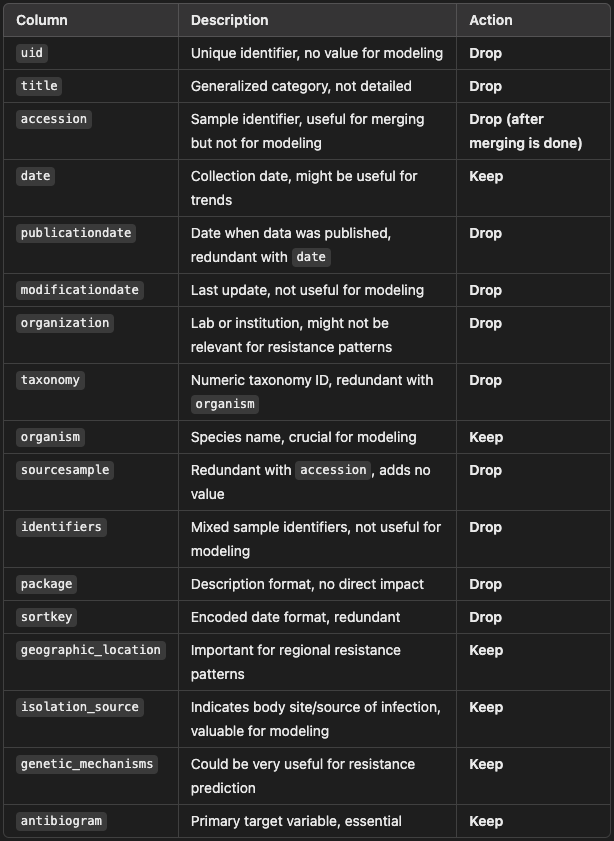

**Final Decision**

✅ **Keep**: `date`, `organism`, `geographic_location`, `isolation_source`, `genetic_mechanisms`, `antibiogram`

❌ **Drop**: `uid`, `title`, `accession`, `publicationdate`, `modificationdate`, `organization`, `taxonomy`, `sourcesample`, `identifiers`, `package`, `sortkey`

🔄 **Transform**: `date` (to check if time-based trends matter, extract year/month), `geographic_location` (keep just the countries)

**Execution**

In [ ]:
# 💡  Drop: Say goodbye to the not-so-useful columns.

df = df.drop(columns=["uid", "title", "publicationdate", "modificationdate", "identifiers", "package", "sortkey","organization","sourcesample", "taxonomy"])

# 💡  Transform:

# 💡  Keeping just the countries, without the cities, to better cohesion.

df["geographic_location"] = df["geographic_location"].str.split(":").str[0]

# 💡  Reconvert the date format to just keep the month and year, again, just for cohesion.
df["date"] = pd.to_datetime(df["date"], errors='coerce').dt.to_period("M")

# 💡  Checking everything is good.
df.head(3)

We'll save at this point, since it'll be our final, mother dataset:

In [ ]:
# 🛠️ Let's do some data magic
df.to_csv(r'../data/interim/final_data_base.csv', index= False)



## 3. Data Exploration

### 3.1 Basic organisms distributions

In [ ]:
# 💡  As there are just too many individual organisms, we'll use a function to group them based on their genus.
# 💡  (e.g. all Salmonellas will be on a group called "Salmonella spp")

# 💡  First we create a copy of our DF

data = df.copy()

# 💡  Easy function to make groups based on the first word of the name.
def genus_grouping(name):
    return name.split()[0].lower().capitalize() + " spp."

# 💡  We aplly it.
data["organism_group"] = data["organism"].apply(genus_grouping)

# 💡  Count occurrences.
organism_counts = data["organism_group"].value_counts()

# 💡  Show 'em.
plt.figure(figsize=(12, 6))
organism_counts.plot(kind="bar", color='skyblue', edgecolor='black', width=0.8)
plt.xticks(rotation=90, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Organism Group", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.title("Organism Distribution (by Genus)", fontsize=16)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

💡 These heatmaps give us a quick glance at resistance and susceptibility trends across species. It's clear that some species have a notorious resistance pattern. We'll need to keep an eye on them in modeling.

As we see, the dataset's most common genera—Salmonella, Escherichia coli, Staphylococcus, Klebsiella, and Pseudomonas—align with real-world infection patterns. Their prevalence suggests a mix of **nosocomial infections** and **foodborne pathogens**.

**Nosocomial Infections:**

- `E. coli`, `Klebsiella`, `Pseudomonas`, `Acinetobacter`, and `Staphylococcus` are major culprits of **hospital-acquired infections**, particularly in ICUs. Their frequent antibiotic resistance makes them key surveillance targets.

**Foodborne Pathogens:**

- `Salmonella` and `Campylobacter` are leading causes of foodborne illnesses, responsible for millions of cases worldwide. Their high presence suggests the dataset includes clinical or epidemiological monitoring data.

Now let's see more on detail:

### 3.1.1 Organisms by species

In [ ]:
# 💡  First we get the Genus (first word) and Species (first two words, we're doing this because there're many subspecies).
data["genus"] = data["organism"].str.split().str[0]
data["species"] = data["organism"].str.split().str[:2].str.join(" ")

# 💡  We count unique species per genus.
genus_species_counts = data.groupby("genus")["species"].nunique()

# 💡  Then we filter: Keep only genera with more than one species.
multi_species_genera = genus_species_counts[genus_species_counts > 1].index.tolist()

# 💡  We create a filter dataset to keep only relevant genera.
filtered_df = data[data["genus"].isin(multi_species_genera)]

# 💡  Determine dimensions of our grid.
num_genera = len(multi_species_genera)
cols = 4
rows = math.ceil(num_genera / cols)

# 💡  We begin to create the grid.
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten()

# 💡  Use a loop to generate individual bar charts for each genus.
for i, genus in enumerate(multi_species_genera):
    genus_df = filtered_df[filtered_df["genus"] == genus]
    species_counts = genus_df["species"].value_counts()

    axes[i].bar(species_counts.index, species_counts.values, color='skyblue', edgecolor='black', width=0.8)
    axes[i].set_title(f"{genus} Species", fontsize=16)
    axes[i].set_ylabel("Count", fontsize=14)
    axes[i].tick_params(axis="x", rotation=90, labelsize=12, labelrotation=90, which="both")
    axes[i].tick_params(axis="y", labelsize=12)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

# 💡  Hide any unused subplots.
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

💡 This graph shows the complex relationship between bacterial groups and antibiotics. The connections tell us which antibiotics are frequently tested against which bacteria—and hint at potential gaps or biases in testing.

**General Conclusions:**

**Hospital-Associated Pathogens Dominate**

- `Klebsiella`, `Acinetobacter`, `Enterococcus`, `Pseudomonas`, and `Staphylococcus` are the most frequent, aligning with their role in nosocomial infections.

**High Species Diversity in Some Genera**

- `Pseudomonas` and `Staphylococcus` show multiple species, while `Salmonella` is dominated by `S. enterica` (and its subtypes).

**Epidemiologically Relevant Bacteria**

- The prevalence of `K. pneumoniae`, `A. baumannii`, `E. faecium`, `P. aeruginosa`, and `S. aureus` matches WHO’s list of critical antibiotic-resistant pathogens.

### 3.2 Antibiotic Resistance

In [ ]:
# 💡  First we create a Dict to make the counts.

resistance_counts = {}
for row in data['antibiogram'].dropna():
    for antibiotic, resistance in eval(row).items():
        if antibiotic not in resistance_counts:
            resistance_counts[antibiotic] = {}
        if resistance not in resistance_counts[antibiotic]:
            resistance_counts[antibiotic][resistance] = 0
        resistance_counts[antibiotic][resistance] += 1

# 💡  Convert Dict to DataFrame and fill missing values with 0.
res_df = pd.DataFrame(resistance_counts).T.fillna(0)

# 💡  Show 'em.
res_df.plot(kind='bar', stacked=True, figsize=(20, 6))
plt.title("Antibiotic Resistance Distribution")
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylabel("Count", fontsize=14)
plt.xlabel("Antibiotics", fontsize=14)
plt.title("Antibiotic Resistance Distribution", fontsize=16)
plt.legend(title="Resistance Type", fontsize=12)
plt.show()

💡 This visualization helps us understand the data structure.

Some insights for the data:

- **High Susceptibility for Beta-Lactams and Carbapenems**: Antibiotics like meropenem, imipenem, and cefepime show a strong dominance of susceptibility, indicating their continued effectiveness. Carbapenems, in particular, are broad-spectrum antibiotics often used as a last resort, which explains their relatively low resistance rates—likely due to their restricted clinical use compared to other antibiotics.

- **Significant Resistance in Fluoroquinolones and Tetracyclines**: Ciprofloxacin, levofloxacin, and tetracycline display notable resistance. Fluoroquinolone resistance has been increasing globally, partly due to their widespread use in both human medicine and agriculture. Tetracycline resistance is also expected since it has been widely used for decades in both clinical and veterinary settings.

### 3.2.1 Top Antibiotic Susceptibility and Resistance

In [ ]:
# 💡  Dict to store resistance counts.
resistance_counts = {}

# 💡  Process AB entries.
for row in data['antibiogram'].dropna():
    for antibiotic, resistance in eval(row).items():
        if antibiotic not in resistance_counts:
            resistance_counts[antibiotic] = {'resistant': 0, 'susceptible': 0}  # 💡  Track resistance & susceptibility
        if resistance == 'resistant':
            resistance_counts[antibiotic]['resistant'] += 1
        elif resistance == 'susceptible':
            resistance_counts[antibiotic]['susceptible'] += 1

# 💡  Convert to DataFrame and sort.
res_df = pd.DataFrame(resistance_counts).T.fillna(0)
top_10_resistant = res_df.sort_values(by='resistant', ascending=False).head(10)
top_10_susceptible = res_df.sort_values(by='susceptible', ascending=False).head(10)

# 💡  Plot results side-by-side.
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 💡  Plot resistant antibiotics.
axes[0].bar(top_10_resistant.index, top_10_resistant['resistant'], color='orange', edgecolor='black')
axes[0].set_title("Top 10 Antibiotics by Resistance", fontsize=14)
axes[0].set_ylabel("Count", fontsize=12)
axes[0].set_xticks(range(len(top_10_resistant.index)))
axes[0].set_xticklabels(top_10_resistant.index, rotation=45, ha='right')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# 💡  Plot susceptible antibiotics.
axes[1].bar(top_10_susceptible.index, top_10_susceptible['susceptible'], color='green', edgecolor='black')
axes[1].set_title("Top 10 Antibiotics by Susceptibility", fontsize=14)
axes[1].set_ylabel("Count", fontsize=12)
axes[1].set_xticks(range(len(top_10_susceptible.index)))
axes[1].set_xticklabels(top_10_susceptible.index, rotation=45, ha='right')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# 💡  Show 'em.
plt.tight_layout()
plt.show()

💡 This visualization helps us understand the data structure.

1. **Most Resisted Antibiotics:**

These findings suggest widespread resistance to these drugs, which aligns with known clinical trends:

- **Tetracycline & Ampicillin:** These are older antibiotics that have been extensively used for decades in both human and veterinary medicine, contributing to bacterial adaptation and resistance.
- **Ciprofloxacin:** A commonly prescribed fluoroquinolone, its overuse in both community and hospital settings has accelerated resistance development.
- **Ceftriaxone:** A broad-spectrum cephalosporin, resistance to this antibiotic is particularly concerning because it is often used for severe infections like pneumonia and sepsis.

2. **Most Susceptible Antibiotics:**

On the other hand, gentamicin, ciprofloxacin, trimethoprim-sulfamethoxazole, and meropenem show high susceptibility rates, meaning bacteria are more likely to be sensitive to these treatments.

- **Gentamicin:** An aminoglycoside primarily used in severe infections, resistance remains relatively low due to its limited use outside hospital settings.
- **Meropenem:** A carbapenem, which is often reserved as a last-resort antibiotic, retains effectiveness against many resistant bacteria. However, its increased susceptibility may also indicate lack of widespread overuse compared to other classes.
- **Trimethoprim-Sulfamethoxazole & Nalidixic Acid:** These antibiotics still show significant effectiveness, but their use should be closely monitored, since Trim-Sulf is usually a very common oral prescribed antibiotic.

### 3.2.2 Antibiotic Resistance by Class

In [ ]:
# 💡  After a lot of investigation, we came with a classification of each Antibiotic on the dataset.

antibiotic_classes = {
    'Penicillins': ['penicillin', 'benzylpenicillin', 'ampicillin', 'amoxicillin', 'amoxicillin-clavulanic_acid',
                    'piperacillin', 'piperacillin-tazobactam', 'ticarcillin', 'ticarcillin-clavulanic_acid',
                    'carbenicillin', 'nafcillin', 'oxacillin', 'dicloxacillin', 'temocillin', 'mecillinam'],

    'Cephalosporins (1G)': ['cephalexin', 'cefalexin', 'cefazolin', 'cephalothin', 'cefalotin'],
    'Cephalosporins (2G)': ['cefuroxime', 'cefamandole', 'cefotetan', 'cefoxitin'],
    'Cephalosporins (3G)': ['ceftriaxone', 'cefotaxime', 'cefpodoxime', 'ceftazidime', 'ceftazidime-clavulanic_acid','ceftizoxime', 'cefoperazone', 'cefixime','cefdinir'],
    'Cephalosporins (4G)': ['cefepime'],
    'Cephalosporins (5G)': ['ceftaroline', 'cefiderocol'],

    'Carbapenems': ['imipenem', 'imipenem-edta-pa', 'imipenem-relebactam', 'meropenem', 'meropenem-vaborbactam','ertapenem', 'doripenem'],
    'Monobactams': ['aztreonam'],
    'β-lactamase inhibitors': ['sulbactam', 'clavulanic_acid', 'tazobactam'],
    'Combination β-lactams': ['ampicillin-sulbactam', 'amoxicillin-clavulanate', 'ticarcillin-clavulanic_acid','cefotaxime-clavulanic_acid', 'ceftolozane-tazobactam','ceftazidime-avibactam'],
    'Veterinary Cephalosporins': ['ceftiofur', 'cefovecin'],

    'Quinolones': ['danofloxacin','ofloxacin', 'norfloxacin','delafloxacin', 'fluoroquinolone','marbofloxacin','ciprofloxacin', 'levofloxacin', 'moxifloxacin', 'norflaxacin', 'enrofloxacin', 'pradofloxacin', 'orbifloxacin', 'nalidixic_acid'],
    'Aminoglycosides': ['capreomycin', 'gentamicin', 'spectinomycin','tobramycin', 'amikacin', 'kanamycin', 'netilmicin', 'apramycin', 'streptomycin', 'neomycin', 'plazomicin'],
    'Tetracyclines': ['eravacycline','tetracycline', 'doxycycline', 'minocycline', 'oxytetracycline', 'chlortetracycline', 'tigecycline', 'omadacycline', 'tilmicosin'],
    'Sulfonamides': ['sulfonamide','trimethoprim-sulfamethoxazole', 'sulfisoxazole', 'sulfadimethoxine', 'sulfamethoxazole','bactrim', ],
    'Macrolides': ['azithromycin', 'tylosin','fidaxomicin','clarithromycin','surotomycin', 'erythromycin', 'telithromycin', 'spiramycin', 'midecamycin','tulathromycin'],
    'Glycopeptides': ['vancomycin', 'teicoplanin', 'oritavancin'],
    'Lincosamides': ['clindamycin', 'lincomycin'],
    'Polypeptides': ['polymyxin_b', 'colistin', 'polymyxin''bacitracin'],
    'Nitrofurans': ['nitrofurantoin', 'pefloxacin'],
    'Bacteriostatics': ['triclosan','ethambutol','florfenicol', 'bacteriostatic'],
    'Anti-Mycobacterium': ['isoniazid','rifabutin', 'rifampin', 'pyrazinamide', 'ethionamide', 'dapsone','cycloserine'],
    'Antifungal': ['posaconazole','itraconazole', 'micafungin', 'caspofungin', 'anidulafungin','fluconazole', 'flucytosine', 'isavuconazole','amphotericin_b','voriconazole'],
    'Oxasolidinones':['tedizolid', 'linezolid'],
    'Other': ['chloramphenicol','daptomycin','metronidazole', 'rifaximin', 'mupirocin','ticlopidine','fosfomycin','trimethoprim','fusidic_acid', 'tiamulin', 'novobiocin','synercid','fosfomycin-glucose-6-phosphate', 'avilamycin','zoliflodacin','quinupristin-dalfopristin','quinupristin'],
}



# 💡  This way we can observe how common is the resistance of each group of antibiotics. We'll do a count.
class_resistance = {}
for row in data['antibiogram'].dropna():
    for antibiotic, resistance in eval(row).items():
        class_name = next((cls for cls, abx in antibiotic_classes.items() if antibiotic in abx), 'Unknown')
        if class_name not in class_resistance:
            class_resistance[class_name] = {}
        if resistance not in class_resistance[class_name]:
            class_resistance[class_name][resistance] = 0
        class_resistance[class_name][resistance] += 1

# 💡  Then we convert it to DF, drop the useless columns and show it.
class_res_df = pd.DataFrame(class_resistance).T
class_res_df = class_res_df.drop(columns= "not defined", index= "Unknown")
class_res_df.plot(kind='bar', stacked=True, figsize=(20, 6))
plt.title("Antibiotic Resistance Distribution by Class")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.legend(title="Resistance Type")
plt.show()

💡 This visualization helps us understand the data structure.

From this plot we can say:

- We confirm that **Quinolones**, **penicillins**, and **tetracyclines** exhibit some of the highest resistance levels, suggesting widespread resistance mechanisms against these classes, possibly due to their frequent clinical use.

- **Cephalosporins** (3rd and 4th generation) and **carbapenems** show lower resistance rates, indicating they may still be effective in many cases.

- **Aminoglycosides** have high susceptibility rates but also significant resistance, likely due to selective pressure from their use in severe infections.

- Classes like **polypeptides**, **glycopeptides**, and **oxazolidinones** show minimal resistance, possibly because they are used for multidrug-resistant infections.

### 3.2.3 Antibiotic Resistance by Organism

In [ ]:
# 💡  Dict check, just in case.
data['antibiogram'] = data['antibiogram'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 💡  Expand the 'antibiogram' column into separate antibiotic columns.
df_expanded = data[['species']].join(pd.DataFrame(data['antibiogram'].tolist()))

# 💡  Reshape data to long format for easier processing.
df_melting = df_expanded.melt(id_vars=['species'], var_name='antibiotic', value_name='result')

# 💡  Use Counter to... Count Resistances and Susceptibilities.
result_counts = Counter(
    (row.species, row.antibiotic, row.result)
    for _, row in df_melting.dropna().iterrows())

# 💡  Convert Counter to DataFrame.
resistance_counts = pd.DataFrame(result_counts, index=[0]).T.reset_index()
resistance_counts.columns = ['species', 'antibiotic', 'result', 'count']

# 💡  Pivot the DataFrame to get resistance and susceptibility counts.
resistance_pivot = resistance_counts.pivot_table(index=['species', 'antibiotic'],
                                                 columns='result', values='count', fill_value=0)

# 💡  Ensure columns exist for both categories.
if 'resistant' not in resistance_pivot:
    resistance_pivot['resistant'] = 0
if 'susceptible' not in resistance_pivot:
    resistance_pivot['susceptible'] = 0

# 💡  Then we use the countings and the total to compute the percentages.
resistance_pivot['total'] = resistance_pivot['resistant'] + resistance_pivot['susceptible']
resistance_pivot['resistance_percentage'] = (resistance_pivot['resistant'] / resistance_pivot['total']) * 100

# 💡  Select the top 20 most common antibiotics and species, then we filter the data.
top_20_antibiotics = resistance_pivot.groupby('antibiotic')['total'].sum().nlargest(20).index
top_20_species = resistance_pivot.groupby('species')['total'].sum().nlargest(20).index
resistance_pivot = resistance_pivot.loc[
    (resistance_pivot.index.get_level_values(0).isin(top_20_species)) &
    (resistance_pivot.index.get_level_values(1).isin(top_20_antibiotics))]

# 💡  Pivot again to get the right format for visualization.
resistance_percentage = resistance_pivot['resistance_percentage'].unstack()

# 💡  Show 'em.
plt.figure(figsize=(15, 8))
sns.heatmap(resistance_percentage, cmap='Reds', annot=True, fmt='.1f', cbar_kws={'label': 'Resistance Percentage'})
plt.title('Resistance Percentage per Bacterium')
plt.xlabel('Antibiotic')
plt.ylabel('Species')
plt.tight_layout()
plt.show()


💡 This visualization helps us understand the data structure.

**Key Findings from the Resistance Data:**

- **Critical Resistance in Klebsiella & Acinetobacter:** These species show near-total resistance (>90%) to multiple antibiotics, aligning with real-world concerns where Klebsiella pneumoniae and Acinetobacter baumannii are known for multidrug resistance in hospital settings.

- **Worrying Resistance in Common Pathogens:** Escherichia coli and Salmonella enterica, two of the most common bacteria, show moderate to high resistance (30-50%) to key antibiotics like ciprofloxacin and ampicillin, reflecting global trends in increasing resistance due to overuse.

- **Unexpected High Resistance in Some Cases:** Azithromycin resistance in Escherichia coli is unusually high, which is uncommon in clinical settings—this could indicate regional resistance trends or data bias that should be further investigated.

**Genetic Mechanisms:**

Before we are able to access the information, we need to do some preprocessing with the data, taking some things in consideration:

- The `genetic_mechanism` column's data is on list-list-dict format, as some bacteria (with the same BioSample ID) could have multiple genetic mechanisms.

- There's a lot of organisms that lacks of `genetic_mechanisms` information (they either don't have any or it wasn't studied). So there's a lot of null values.

In [ ]:
# 💡  First, we need to parse the information in the genetic_mechanism colum.

def parsing_gen_m(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return None
    return x

data['genetic_mechanisms'] = data['genetic_mechanisms'].apply(parsing_gen_m)

# 💡  Filter the data to just show the information of bacteria WITH genetic_mechanism info.

df_filtered = data[data['genetic_mechanisms'].apply(lambda x: isinstance(x, list) and len(x) > 0)].copy()

# 💡  Extract genetic mechanisms, using the Element symbol as the "ID".
df_filtered['mechanisms'] = df_filtered['genetic_mechanisms'].apply(
    lambda lst: [m['Element symbol'] for m in lst if isinstance(m, dict) and 'Element symbol' in m])

In [ ]:

# 💡  Flatten the list of genetic mechanisms across all rows
all_mechanisms = [m for lst in df_filtered['mechanisms'].dropna() for m in lst]

# 💡  Count occurrences of each genetic mechanism
mechanism_counts = Counter(all_mechanisms)

# 💡  Convert to DataFrame
df_mechanisms = pd.DataFrame(mechanism_counts.items(), columns=['Mechanism', 'Count'])

# 💡  Sort and keep the top 20 most frequent mechanisms
df_mechanisms = df_mechanisms.sort_values(by='Count', ascending=False).head(20)

# 💡  Plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Count', y='Mechanism', data=df_mechanisms, hue='Mechanism', palette="Blues_r")
plt.xlabel("Frequency")
plt.ylabel("Resistance Gene")
plt.title("Top 20 Most Frequent Genetic Mechanisms")
plt.show()

💡 This visualization helps us understand the data structure.

In [ ]:
# 💡  First: We extract genetic mechanisms, using the Element symbol as the "ID".
df_filtered['mechanisms'] = df_filtered['genetic_mechanisms'].apply(
    lambda lst: [m['Element symbol'] for m in lst if isinstance(m, dict) and 'Element symbol' in m]
)

# 💡  Second: We count occurrences of each genetic mechanism and we filter to 30 of the most commons as a sample (there's too much).
mechanism_counts = df_filtered.explode('mechanisms')['mechanisms'].value_counts()
top_mechanisms = mechanism_counts.nlargest(30).index

# 💡  Third: We filter the dataframe to keep only the top mechanisms.
df_filtered = df_filtered[df_filtered['mechanisms'].apply(lambda lst: any(m in top_mechanisms for m in lst))]

# 💡  Fourh: We explode the filtered dataframe to have them all as columns.
df_exploded = df_filtered.explode('mechanisms')

# 💡  Fifth: Creating the heatmap data.
heatmap_data = df_exploded.pivot_table(
    index='species', columns='mechanisms', aggfunc='size', fill_value=0)

# 💡  Sixth: Make some conversions for the data to show more clearly:
# 💡  Convert to numeric, filter non-zero rows/columns and apply log transformation.

heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
heatmap_data = heatmap_data.loc[(heatmap_data != 0).any(axis=1), (heatmap_data != 0).any(axis=0)]
heatmap_data = np.log1p(heatmap_data)

# 💡  Show 'em
plt.figure(figsize=(20, 12))
sns.heatmap(heatmap_data, cmap="Blues", linewidths=0.5)
plt.title(f"Genetic Mechanisms by Species")
plt.xlabel("Genetic Mechanisms")
plt.ylabel("Species")
plt.xticks(rotation=90)
plt.show()


💡 This visualization helps us understand the data structure.

Some general insight:

- Escherichia coli, Klebsiella pneumoniae, and Pseudomonas aeruginosa show a higher density of resistance mechanisms, indicating a broader range of genetic resistance.

- Some resistance mechanisms appear across multiple genera, while others are species-specific, suggesting different evolutionary or acquisition patterns.

**Potential Key Findings:**

- Klebsiella and Escherichia share many resistance genes, likely due to genetic exchange, while Pseudomonas aeruginosa has a distinct resistance profile.

- Rare resistance mechanisms appear at the edges of the heatmap, possibly representing less common or emerging resistance traits.

In [ ]:
# 💡 Build a binary matrix for resistance mechanisms
mechanisms = set(mech for sublist in df_filtered["mechanisms"] for mech in sublist)
mech_df = pd.DataFrame({mech: df_filtered["mechanisms"].apply(lambda x: mech in x).astype(int) for mech in mechanisms})

# 💡 Build a binary matrix for antibiotic groups
ab_resistance = pd.DataFrame({
    group: df_filtered["antibiogram"].apply(lambda x: any(x.get(ab) == "resistant" for ab in ab_list)).astype(int)
    for group, ab_list in antibiotic_classes.items()
})

# 💡 Merge both DataFrames into a single table
df_combined = pd.concat([mech_df, ab_resistance], axis=1)

# 💡 Calculate and filter the correlation matrix
corr_matrix = df_combined.corr()
filtered_corr = corr_matrix.loc[mech_df.columns, ab_resistance.columns]

# 💡 Split mechanisms by correlation threshold
threshold = 0.3
top_mechanisms = filtered_corr[filtered_corr.abs().max(axis=1) >= threshold]
remaining_mechanisms = filtered_corr[filtered_corr.abs().max(axis=1) < threshold]

# 💡 Plot side-by-side heatmaps to visualize the dance between mechanisms and antibiotics
fig, axes = plt.subplots(1, 2, figsize=(24, 14))

# 💡 Heatmap of highly correlated mechanisms
sns.heatmap(top_mechanisms, cmap="coolwarm", center=0, ax=axes[0])
axes[0].set_title("Top Correlated Mechanisms")

# 💡 Heatmap of the less glamorous, low correlation mechanisms
sns.heatmap(remaining_mechanisms, cmap="coolwarm", center=0, ax=axes[1])
axes[1].set_title("Remaining Mechanisms")

plt.tight_layout()
plt.show()

💡 This visualization helps us understand the data structure.

Some of the highlights extracted from the data:

**β-Lactam Resistance (Penicillins, Cephalosporins, Carbapenems):**


**blaOXA, blaCTX-M, blaCMY, blaNDM, blaSHV, blaTEM** genes show strong correlations with **β-lactam antibiotic classes**.

* These genes encode β-lactamases, enzymes that hydrolyze β-lactam rings, inactivating the antibiotic.

* Example: **blaCTX-M** is known for conferring resistance to third-generation **cephalosporins** (Ceftriaxone, Ceftazidime), which aligns with its high correlation in the heatmap.


**blaOXA-23, blaOXA-48, blaNDM-1** correlate strongly with **Carbapenem** resistance (Imipenem, Meropenem).

* These genes are carbapenemases, breaking down carbapenems and making them ineffective.
* Example: **blaNDM-1** is highly associated with Carbapenem-resistant Enterobacteriaceae (CRE) outbreaks worldwide.


**Fluoroquinolone Resistance (Ciprofloxacin, Levofloxacin):**

**qnr, aac(6')-Ib-cr, gyrA, parC** mutations show high correlation with fluoroquinolone resistance.

* Fluoroquinolones target **DNA gyrase** (gyrA) and **topoisomerase IV** (parC), so mutations in these genes reduce antibiotic binding.
* Example: **qnr** genes provide protection to **DNA gyrase**, lowering drug efficacy, often found in *E. coli* and *Klebsiella pneumoniae.*


**Aminoglycoside Resistance (Gentamicin, Amikacin):**

**aac(3)-II, aac(6')-Ib, ant(2'')-Ia, aph(3')-VIa** correlate with aminoglycoside resistance.

* These genes encode aminoglycoside-modifying enzymes that inactivate the antibiotic by acetylation, adenylation, or phosphorylation.
* Example: **aac(6')-Ib** is widely found in *Pseudomonas aeruginosa* and *Enterobacteriaceae*.

**Macrolide Resistance (Erythromycin, Azithromycin):**

**erm(B), mph(A), mef(A)** correlate strongly with macrolide resistance.

* erm(B) confers resistance by methylating the 23S rRNA, preventing macrolide binding.
* Example: **erm** genes are often found in *Streptococcus pneumoniae* and *Staphylococcus aureus*, leading to MLS (Macrolide-Lincosamide-Streptogramin) resistance.

**Sulfonamide & Trimethoprim Resistance**

**sul1, sul2 (sulfonamide resistance) and dfrA (trimethoprim resistance)** show strong positive correlations with their respective drug classes.

* sul genes encode mutant dihydropteroate synthase, making sulfonamides ineffective.
* Example: sul2 is common in plasmids of multi-drug-resistant (MDR) E. coli.


In [ ]:
# 💡 Build connections between genes and bacterial families
gene_family_connections = {}

for _, row in df_filtered.iterrows():
    family = row["organism_group"]
    genes = row["mechanisms"]

    for gene in genes:
        if gene not in gene_family_connections:
            gene_family_connections[gene] = set()
        gene_family_connections[gene].add(family)

# 💡 Filter out genes found in only one family (cleaning up the noise)
gene_family_connections = {gene: families for gene, families in gene_family_connections.items() if len(families) > 1}

# 💡 Time to build the graph!
G = nx.Graph()

for gene, families in gene_family_connections.items():
    G.add_node(gene, type="gene")  # 💡 Gene node
    for family in families:
        G.add_node(family, type="family")  # 💡 Bacterial family node
        G.add_edge(gene, family)  # 💡 Connect gene with family

# 💡 Calculate centrality and degree metrics to find the key players
centrality = nx.betweenness_centrality(G)
degree = dict(G.degree())

# 💡 Adjust node sizes based on their connections
node_sizes = {node: 300 + degree[node] * 15 for node in G.nodes}

# 💡 Highlight only the most central nodes (top influencers)
top_central_nodes = {node for node, val in sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:40]}

# 💡 Use a layout that gives everyone room to breathe
plt.figure(figsize=(18, 14))
pos = nx.fruchterman_reingold_layout(G)

# 💡 Split nodes by type for better coloring
nodes_gene = [node for node, attr in G.nodes(data=True) if attr["type"] == "gene"]
nodes_family = [node for node, attr in G.nodes(data=True) if attr["type"] == "family"]

# 💡 Draw the nodes with transparency for a cleaner look
nx.draw_networkx_nodes(G, pos, nodelist=nodes_gene, node_color="red", alpha=0.7, node_size=[node_sizes[n] for n in nodes_gene])
nx.draw_networkx_nodes(G, pos, nodelist=nodes_family, node_color="blue", alpha=0.8, node_size=[node_sizes[n] for n in nodes_family])
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# 💡 Add labels only to the VIP nodes (top central ones)
labels = {node: node for node in G.nodes if node in top_central_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8, font_color="black")

plt.title("Network of Resistance Genes Shared Among Bacterial Families")
plt.show()

# 💡 Let's see who runs the microbial show—top genes by centrality
sorted_centrality = sorted(centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 genes by betweenness centrality:")
for gene, value in sorted_centrality[:10]:
    print(f"{gene}: {value:.4f}")

💡 This visualization helps us understand the data structure.

**Key Observations & Conclusions:**

**Escherichia spp. and Klebsiella spp. are the most central**

* These two have the highest betweenness centrality, meaning they serve as key intermediaries connecting different resistance genes and bacterial families.

* This suggests they share resistance mechanisms broadly, possibly acting as reservoirs for antibiotic resistance genes.

**Salmonella spp. and Enterobacter spp. are also highly connected**

* Salmonella’s high centrality suggests it shares resistance genes with multiple families, which could have implications for foodborne infections.

* Enterobacter’s centrality aligns with its known role as a multidrug-resistant pathogen in hospitals.

**Acinetobacter spp. & Pseudomonas spp. appear as hubs**

* Both are opportunistic pathogens often linked to hospital infections. Their position in the network suggests they share resistance genes with multiple families, reinforcing concerns about their adaptability.

**Shigella spp. & Serratia spp. have lower but relevant centrality**

* These species might not be as highly connected but still share important resistance mechanisms, possibly with more specific groups.


In [ ]:
# 💡  Adjust node positions with more spacing
pos = nx.spring_layout(G, seed=42, k=0.35)  # 💡  Increased k for better spacing

plt.figure(figsize=(20, 15))

# 💡  Draw regular genes (red)
nx.draw_networkx_nodes(G, pos, nodelist=nodes_gene, node_color="red", node_size=80)

# 💡  Draw bacterial families (blue)
nx.draw_networkx_nodes(G, pos, nodelist=nodes_family, node_color="blue", node_size=300)

# 💡  Compute degree centrality for all nodes
degree = dict(G.degree())

# 💡  Filter only gene nodes
degree_genes = {gene: degree[gene] for gene in nodes_gene}

# 💡  Select the top 10 most connected genes
top_genes = sorted(degree_genes.items(), key=lambda x: x[1], reverse=True)[:10]

# 💡  Highlight top central genes (yellow) with larger sizes
top_gene_names = [gene for gene, _ in top_genes]
top_gene_sizes = [500 + np.log(degree[gene]) * 300 for gene in top_gene_names]
nx.draw_networkx_nodes(G, pos, nodelist=top_gene_names, node_color="yellow", node_size=top_gene_sizes)

# 💡  Draw edges with even lower opacity to avoid clutter
nx.draw_networkx_edges(G, pos, alpha=0.05)

# 💡  Labels only for top genes and key bacterial families
labels = {node: node for node in top_gene_names}
for family in nodes_family:
    if degree[family] > 10:  # 💡  Label only highly connected families
        labels[family] = family

# 💡  Add labels with white background for better readability
nx.draw_networkx_labels(
    G, pos, labels=labels, font_size=12, font_weight="bold",
    font_color="black", bbox=dict(facecolor="white", alpha=0.6, edgecolor="none")
)

plt.title("Refined Network of Resistance Genes Shared Among Bacterial Families")
plt.show()

💡 This visualization helps us understand the data structure.

**Real-Life Implications of This Network Analysis:**

**Escherichia spp. and Klebsiella spp. as Resistance Hubs: A Public Health Concern**

* Both Escherichia spp. (including E. coli) and Klebsiella spp. are known for their role in hospital-acquired infections (HAIs).
Their high centrality suggests they play a major role in the horizontal transfer of resistance genes.

* Klebsiella pneumoniae, for instance, is notorious for carbapenem resistance (KPC-producing strains), a major clinical challenge.
The frequent genetic exchange in Escherichia coli makes it a key reservoir for resistance genes that can spread to both commensal and pathogenic strains.


**Salmonella spp: Foodborne Pathogen with Increasing Resistance**

* Salmonella spp. is a major cause of foodborne illness worldwide.
Its high centrality indicates that it is acquiring and sharing resistance genes with other bacteria, possibly due to antibiotic use in livestock.

* Multidrug-resistant (MDR) Salmonella strains (e.g., producing extended-spectrum β-lactamases or ESBLs) have been reported in both human and veterinary medicine.


**Enterobacter spp. & Acinetobacter spp: Hospital Hotspots of Resistance**

* Enterobacter spp. and Acinetobacter spp. are well-known causes of bloodstream infections and ventilator-associated pneumonia in hospitalized patients.

* The network suggests they are well-connected, meaning they likely share resistance genes with multiple bacteria, including carbapenemases.

* Acinetobacter baumannii is one of the most dangerous MDR pathogens, commonly resistant to almost all available antibiotics.


**Pseudomonas spp: An Opportunistic Multidrug-Resistant Pathogen**

* Pseudomonas aeruginosa is a classic example of an opportunistic pathogen with intrinsic and acquired resistance mechanisms.

* The network suggests that it is well-integrated, meaning it is likely acquiring resistance genes through horizontal gene transfer (HGT).

**This aligns with real-world data:** P. aeruginosa often carries resistance genes to carbapenems and aminoglycosides, making infections difficult to treat.


**Shigella & Serratia spp:Lower but Still Significant**

* Shigella spp. (related to E. coli) is a major cause of bacterial dysentery. Its presence in this network suggests ongoing gene transfer, which is concerning given its rising resistance to fluoroquinolones and azithromycin.

* Serratia spp. are often underestimated but are emerging in hospital settings, particularly in bloodstream infections.

## ✅ Conclusions & Next Steps

We've successfully peeked into the microbial universe and brought order to the data chaos.
Key takeaways from this EDA adventure:
- The dataset is messy, diverse, and rich—perfect fuel for modeling.
- We spotted patterns in resistance profiles and gaps in metadata we should handle carefully in modeling.
- Genetic markers and organism groups are now aligned and ready to become input for our machine learning wizardry.

### Next Steps:
- Move forward to feature engineering and modeling.
- Start the robustness testing phase (where we'll throw the weirdest samples at the model and see if it panics).

Stay tuned for the next chapter in the Flemming saga. 🚀
